In [715]:
# From this tutorial: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
# Also: https://github.com/Garima13a/Facial-Keypoint-Detection
import torch
import glob
import os
import cv2
from skimage import transform
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from sklearn.model_selection import train_test_split

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [716]:
# get dataframes
train_raw = pd.read_csv('training.csv')
test_raw = pd.read_csv('test.csv')

# remove NA rows
print(train_raw.shape)
train_raw = train_raw.dropna()
train_raw = train_raw.reset_index(drop=True)
print(train_raw.shape)

# split training file for testing
train, test = train_test_split(train_raw, test_size=0.2, random_state=0)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
print(train.shape)
print(test.shape)
print(test_raw.shape)

(7049, 31)
(2140, 31)
(1712, 31)
(428, 31)
(1783, 2)


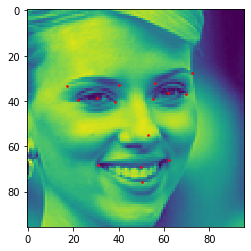

In [717]:
image_num = 552

selected_pix = train['Image'][image_num]
key_pts = train.iloc[image_num, 0:30].as_matrix()
key_pts = key_pts.astype('float').reshape(-1, 2)
# print('Pixels: ', selected_pix)
# print('Landmarks shape: ', key_pts.shape)
# print('First 4 key pts: {}'.format(key_pts[:4]))

# # note to self: pixels are one 0 to 255 value (instead of 3 values) because it is grayscale
image_string = selected_pix.split(' ') #pixels are separated by spaces.
image_data = np.asarray(image_string, dtype=np.uint8).reshape(96,96)
img = Image.fromarray(image_data) #final image

def show_keypoints(image, key_pts):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
show_keypoints(img, key_pts)
plt.show()

In [718]:
class FacialKeypointsDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, dataframe, transform=None):
        """
        Args:
            dataframe: Dataframe to be used.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.key_pts_frame = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.key_pts_frame)

    def __getitem__(self, idx):
        # no image name in our code
        selected_pix = self.key_pts_frame['Image'][idx]
        image_string = selected_pix.split(' ') #pixels are separated by spaces.
        image_data = np.asarray(image_string, dtype=np.uint8).reshape(96,96)
        image = Image.fromarray(image_data) #final image
        
        len_df = len(self.key_pts_frame.columns)
#         print(f"Number of columns in dataframe is {len_df}")
        
        if len_df==2:
            sample = {'image': image}
        else:
            key_pts = self.key_pts_frame.iloc[idx, 0:30].as_matrix()
            key_pts = key_pts.astype('float').reshape(-1, 2)
            sample = {'image': image, 'keypoints': key_pts}

        if self.transform:
            sample = self.transform(sample)
            
        return sample

In [719]:
# Construct the dataset
face_dataset = FacialKeypointsDataset(dataframe=train)

# print some stats about the dataset
print('Length of dataset: ', len(face_dataset))

Length of dataset:  1712


310
0 (15, 2)


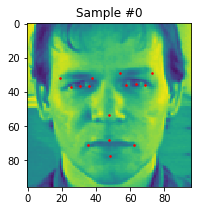

803
1 (15, 2)


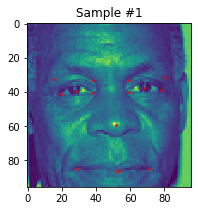

387
2 (15, 2)


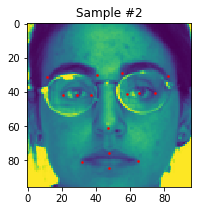

In [720]:
# Display a few of the images from the dataset
num_to_display = 3

for i in range(num_to_display):
    
    # define the size of images
    fig = plt.figure(figsize=(10,10))
    
    # randomly select a sample
    rand_i = np.random.randint(0, len(face_dataset))
    print(rand_i)
    sample = face_dataset[rand_i]

    # print the shape of the image and keypoints
    print(i, sample['keypoints'].shape)

    ax = plt.subplot(1, num_to_display, i + 1)
    ax.set_title('Sample #{}'.format(i))
    
    # Using the same display function, defined earlier
    show_keypoints(sample['image'], sample['keypoints'])
    
# From looking at some of these, it's obvious we have missing keypoints in the training data (might need to clean that up)

In [721]:
class Normalize:
    """Normalize the grayscale range to [0,1]."""   
    def __call__(self, sample):
        image = sample['image']
        image_copy = np.copy(image)
        # scale color range from [0, 255] to [0, 1]
        image_copy = image_copy/255.0
        
        if 'keypoints' in sample:
            key_pts = sample['keypoints']
            key_pts_copy = np.copy(key_pts)
            # scale keypoints to be centered around 0 with a range of [-1, 1]
            # guide does math here differently
            # if every image is 96x96, we should be able to subtract 48 from x and y to have center of image be (0,0) 
            # Then highest value we could have is 48, so we divide by 48 to make that = to 1
            key_pts_copy = (key_pts_copy - 48)/48
            return {'image': image_copy, 'keypoints': key_pts_copy}
        else:
            return {'image': image_copy}
    
# skipping Rescale and RandomCrop classes because our images are already standardized 96x96 pixels

class ToTensor:
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image = sample['image']
        # if image has no grayscale color channel, add one
        if(len(image.shape) == 2):
            # add that third color dim
            image = image.reshape(image.shape[0], image.shape[1], 1)
            
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        
        if 'keypoints' in sample:
            key_pts = sample['keypoints']
            return {'image': torch.from_numpy(image),
                    'keypoints': torch.from_numpy(key_pts)}
        else:
            return {'image': torch.from_numpy(image)}

In [722]:
# define the data transform
data_transform = transforms.Compose([Normalize(),
                                     ToTensor()])

# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(dataframe=train,
                                             transform=data_transform)

In [723]:
# print some stats about the transformed data
print('Number of images: ', len(transformed_dataset))

# make sure the sample tensors are the expected size
for i in range(5):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  1712
0 torch.Size([1, 96, 96]) torch.Size([15, 2])
1 torch.Size([1, 96, 96]) torch.Size([15, 2])
2 torch.Size([1, 96, 96]) torch.Size([15, 2])
3 torch.Size([1, 96, 96]) torch.Size([15, 2])
4 torch.Size([1, 96, 96]) torch.Size([15, 2])


In [724]:
# model
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        ## TODO: Define all the layers of this CNN, the only requirements are:
        ## 1. This network takes in a square (same width and height), grayscale image as input
        ## 2. It ends with a linear layer that represents the keypoints
        ## it's suggested that you make this last layer output 136 values, 2 for each of the 68 keypoint (x, y) pairs
        
        # As an example, you've been given a convolutional layer, which you may (but don't have to) change:
        # 1 input image channel (grayscale), 32 output channels/feature maps, 5x5 square convolution kernel
        
        #obejctive is to bring down the image size to single unit-->
        #here given image size is 96x96px
        self.conv1 = nn.Conv2d(1, 32, 5)
        #96--> 96-5+1=92
        self.pool1 = nn.MaxPool2d(2, 2)
        #92/2=46 ...(32,46,46)
        
        self.conv2 = nn.Conv2d(32, 64, 3)
        #46--> 46-3+1=44
        self.pool2 = nn.MaxPool2d(2, 2)
        #44/2=22
        
        self.conv3 = nn.Conv2d(64, 128, 3)
        #22-->22-3+1=20
        self.pool3 = nn.MaxPool2d(2, 2)
        #20/2=10
        
        self.conv4 = nn.Conv2d(128, 256, 3)
        #10-->10-3+1=8
        self.pool4 = nn.MaxPool2d(2, 2)
        #8/2=4
        
        self.conv5 = nn.Conv2d(256,512,1)
        #4-->4-1+1=4
        self.pool5 = nn.MaxPool2d(2,2)
        #4/2=2
        
        #2x2x512
        self.fc1 = nn.Linear(2*2*512 , 1024)
#         self.fc2 = nn.Linear(1024,1024)
#         doing 30 keypoints here (15*2)
        self.fc2 = nn.Linear(1024,30)
        
        self.drop1 = nn.Dropout(p = 0.1)
        self.drop2 = nn.Dropout(p = 0.2)
        self.drop3 = nn.Dropout(p = 0.3)
        self.drop4 = nn.Dropout(p = 0.4)
        self.drop5 = nn.Dropout(p = 0.5)
        self.drop6 = nn.Dropout(p = 0.6)
        #self.fc2_drop = nn.Dropout(p=.5)
            
        
        ## Note that among the layers to add, consider including:
        # maxpooling layers, multiple conv layers, fully-connected layers, and other layers (such as dropout or batch normalization) to avoid overfitting
        

        
    def forward(self, x):
        ## TODO: Define the feedforward behavior of this model
        ## x is the input image and, as an example, here you may choose to include a pool/conv step:
        x = self.drop1(self.pool1(F.relu(self.conv1(x))))
        x = self.drop2(self.pool2(F.relu(self.conv2(x))))
        x = self.drop3(self.pool3(F.relu(self.conv3(x))))
        x = self.drop4(self.pool4(F.relu(self.conv4(x))))
        x = self.drop5(self.pool5(F.relu(self.conv5(x))))
        x = x.view(x.size(0), -1)
        x = self.drop6(F.relu(self.fc1(x)))
        x = self.fc2(x)
        
        
        
        # a modified x, having gone through all the layers of your model, should be returned
        return x

# instantiate the net
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
  (pool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=30, bias=True)
  (drop1): Dropout(p=0.1, inplace=False)
  (drop2): Dropout(p=0.2, inplace=False)
  (drop3): Dropout(p=0.3, inplace=False)
  (drop

In [725]:
assert(data_transform is not None), 'Define a data_transform'

In [726]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

In [727]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(dataframe=test,
                                             transform=data_transform)

In [728]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

In [729]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)
        
        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 15 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 15, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts

In [730]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 96, 96])
torch.Size([10, 15, 2])
torch.Size([10, 15, 2])


In [731]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=10, marker='.', c='r')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=10, marker='.', c='g')

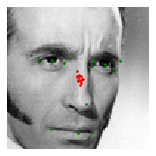

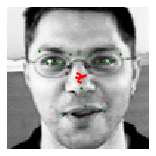

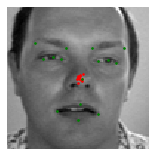

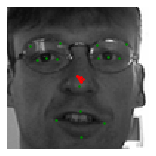

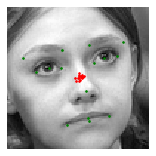

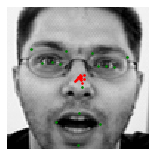

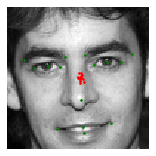

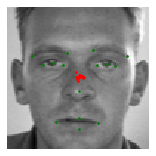

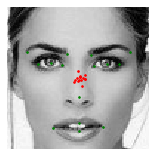

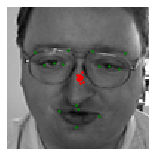

In [732]:

# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(30,30))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*48.0+48
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*48.0+48
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

In [733]:
## TODO: Define the loss and optimization
import torch.optim as optim

#criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()

#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(params = net.parameters(), lr = 0.001)

In [734]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)
            #output_pts = output_pts.type(torch.FloatTensor)
            #print(output_pts.type)
            #print(key_pts.type)
            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/1000))
                running_loss = 0.0

    print('Finished Training')

In [735]:
# train your network
n_epochs = 100 # start small, and increase when you've decided on your model structure and hyperparams

# start training
train_net(n_epochs)

Epoch: 1, Batch: 10, Avg. Loss: 0.0006901079807430506
Epoch: 1, Batch: 20, Avg. Loss: 0.00015606771409511566
Epoch: 1, Batch: 30, Avg. Loss: 0.00011756336502730847
Epoch: 1, Batch: 40, Avg. Loss: 0.00010090620443224907
Epoch: 1, Batch: 50, Avg. Loss: 8.122451417148113e-05
Epoch: 1, Batch: 60, Avg. Loss: 9.526905277743936e-05
Epoch: 1, Batch: 70, Avg. Loss: 7.844188157469034e-05
Epoch: 1, Batch: 80, Avg. Loss: 7.038510218262672e-05
Epoch: 1, Batch: 90, Avg. Loss: 6.968147028237581e-05
Epoch: 1, Batch: 100, Avg. Loss: 8.164206612855196e-05
Epoch: 1, Batch: 110, Avg. Loss: 7.609308883547782e-05
Epoch: 1, Batch: 120, Avg. Loss: 7.158689480274915e-05
Epoch: 1, Batch: 130, Avg. Loss: 7.613124558702112e-05
Epoch: 1, Batch: 140, Avg. Loss: 6.870370358228683e-05
Epoch: 1, Batch: 150, Avg. Loss: 6.773542519658804e-05
Epoch: 1, Batch: 160, Avg. Loss: 7.863617921248079e-05
Epoch: 1, Batch: 170, Avg. Loss: 6.0937185306102036e-05
Epoch: 2, Batch: 10, Avg. Loss: 7.863821694627404e-05
Epoch: 2, Batch:

Epoch: 9, Batch: 160, Avg. Loss: 5.0070315599441525e-05
Epoch: 9, Batch: 170, Avg. Loss: 4.913129727356136e-05
Epoch: 10, Batch: 10, Avg. Loss: 4.9248595489189026e-05
Epoch: 10, Batch: 20, Avg. Loss: 4.712727945297957e-05
Epoch: 10, Batch: 30, Avg. Loss: 5.610788729973137e-05
Epoch: 10, Batch: 40, Avg. Loss: 5.155312176793814e-05
Epoch: 10, Batch: 50, Avg. Loss: 5.2949045319110156e-05
Epoch: 10, Batch: 60, Avg. Loss: 5.059011816047132e-05
Epoch: 10, Batch: 70, Avg. Loss: 4.80955676175654e-05
Epoch: 10, Batch: 80, Avg. Loss: 4.2917451821267604e-05
Epoch: 10, Batch: 90, Avg. Loss: 5.2087250398471954e-05
Epoch: 10, Batch: 100, Avg. Loss: 4.831724939867854e-05
Epoch: 10, Batch: 110, Avg. Loss: 4.442124697379768e-05
Epoch: 10, Batch: 120, Avg. Loss: 5.2578130969777704e-05
Epoch: 10, Batch: 130, Avg. Loss: 4.107232089154422e-05
Epoch: 10, Batch: 140, Avg. Loss: 4.631508095189929e-05
Epoch: 10, Batch: 150, Avg. Loss: 5.720739159733057e-05
Epoch: 10, Batch: 160, Avg. Loss: 5.559397302567959e-0

Epoch: 18, Batch: 110, Avg. Loss: 4.3512998847290875e-05
Epoch: 18, Batch: 120, Avg. Loss: 4.6511429594829676e-05
Epoch: 18, Batch: 130, Avg. Loss: 5.320170917548239e-05
Epoch: 18, Batch: 140, Avg. Loss: 4.812353616580367e-05
Epoch: 18, Batch: 150, Avg. Loss: 4.033251898363233e-05
Epoch: 18, Batch: 160, Avg. Loss: 5.186354531906545e-05
Epoch: 18, Batch: 170, Avg. Loss: 4.5699241803959015e-05
Epoch: 19, Batch: 10, Avg. Loss: 4.703492624685168e-05
Epoch: 19, Batch: 20, Avg. Loss: 5.066401045769453e-05
Epoch: 19, Batch: 30, Avg. Loss: 4.404392605647445e-05
Epoch: 19, Batch: 40, Avg. Loss: 5.221248907037079e-05
Epoch: 19, Batch: 50, Avg. Loss: 5.417367350310087e-05
Epoch: 19, Batch: 60, Avg. Loss: 4.508415306918323e-05
Epoch: 19, Batch: 70, Avg. Loss: 5.063090589828789e-05
Epoch: 19, Batch: 80, Avg. Loss: 4.513011407107115e-05
Epoch: 19, Batch: 90, Avg. Loss: 4.783626552671194e-05
Epoch: 19, Batch: 100, Avg. Loss: 4.9190520076081154e-05
Epoch: 19, Batch: 110, Avg. Loss: 4.160686233080924e-

Epoch: 27, Batch: 60, Avg. Loss: 5.111125158146024e-05
Epoch: 27, Batch: 70, Avg. Loss: 4.364742152392864e-05
Epoch: 27, Batch: 80, Avg. Loss: 4.327208758331835e-05
Epoch: 27, Batch: 90, Avg. Loss: 4.4259254587814213e-05
Epoch: 27, Batch: 100, Avg. Loss: 3.833524440415204e-05
Epoch: 27, Batch: 110, Avg. Loss: 4.1889874963089826e-05
Epoch: 27, Batch: 120, Avg. Loss: 4.4293124927207824e-05
Epoch: 27, Batch: 130, Avg. Loss: 4.4975477969273924e-05
Epoch: 27, Batch: 140, Avg. Loss: 5.1732267485931515e-05
Epoch: 27, Batch: 150, Avg. Loss: 4.0588452015072106e-05
Epoch: 27, Batch: 160, Avg. Loss: 4.409331921488047e-05
Epoch: 27, Batch: 170, Avg. Loss: 4.576872708275914e-05
Epoch: 28, Batch: 10, Avg. Loss: 4.3881530640646816e-05
Epoch: 28, Batch: 20, Avg. Loss: 5.0660626497119664e-05
Epoch: 28, Batch: 30, Avg. Loss: 4.831331153400242e-05
Epoch: 28, Batch: 40, Avg. Loss: 4.023440345190465e-05
Epoch: 28, Batch: 50, Avg. Loss: 4.137126298155636e-05
Epoch: 28, Batch: 60, Avg. Loss: 3.57282408513128

Epoch: 35, Batch: 170, Avg. Loss: 4.1830121539533135e-05
Epoch: 36, Batch: 10, Avg. Loss: 4.1432181606069205e-05
Epoch: 36, Batch: 20, Avg. Loss: 4.089634888805449e-05
Epoch: 36, Batch: 30, Avg. Loss: 3.9375758031383155e-05
Epoch: 36, Batch: 40, Avg. Loss: 3.868167148903012e-05
Epoch: 36, Batch: 50, Avg. Loss: 4.1003490099683405e-05
Epoch: 36, Batch: 60, Avg. Loss: 4.583555483259261e-05
Epoch: 36, Batch: 70, Avg. Loss: 3.7834263406693935e-05
Epoch: 36, Batch: 80, Avg. Loss: 3.874183655716479e-05
Epoch: 36, Batch: 90, Avg. Loss: 4.005582933314145e-05
Epoch: 36, Batch: 100, Avg. Loss: 3.84035708848387e-05
Epoch: 36, Batch: 110, Avg. Loss: 3.6750491010025145e-05
Epoch: 36, Batch: 120, Avg. Loss: 3.6204108502715826e-05
Epoch: 36, Batch: 130, Avg. Loss: 4.256783123128116e-05
Epoch: 36, Batch: 140, Avg. Loss: 3.521458082832396e-05
Epoch: 36, Batch: 150, Avg. Loss: 4.755746223963797e-05
Epoch: 36, Batch: 160, Avg. Loss: 4.111266555264592e-05
Epoch: 36, Batch: 170, Avg. Loss: 4.226020234636962

Epoch: 44, Batch: 120, Avg. Loss: 2.7116179815493525e-05
Epoch: 44, Batch: 130, Avg. Loss: 3.3676054561510685e-05
Epoch: 44, Batch: 140, Avg. Loss: 3.2656473340466615e-05
Epoch: 44, Batch: 150, Avg. Loss: 3.0643331934697927e-05
Epoch: 44, Batch: 160, Avg. Loss: 3.26772858388722e-05
Epoch: 44, Batch: 170, Avg. Loss: 3.612001403234899e-05
Epoch: 45, Batch: 10, Avg. Loss: 3.383760480210185e-05
Epoch: 45, Batch: 20, Avg. Loss: 2.8393547050654888e-05
Epoch: 45, Batch: 30, Avg. Loss: 3.5898036556318405e-05
Epoch: 45, Batch: 40, Avg. Loss: 2.9767901520244776e-05
Epoch: 45, Batch: 50, Avg. Loss: 3.489451482892036e-05
Epoch: 45, Batch: 60, Avg. Loss: 3.343404259067029e-05
Epoch: 45, Batch: 70, Avg. Loss: 3.739913436584175e-05
Epoch: 45, Batch: 80, Avg. Loss: 3.2212109304964544e-05
Epoch: 45, Batch: 90, Avg. Loss: 3.3245440572500226e-05
Epoch: 45, Batch: 100, Avg. Loss: 3.140721330419183e-05
Epoch: 45, Batch: 110, Avg. Loss: 3.679356095381081e-05
Epoch: 45, Batch: 120, Avg. Loss: 2.9912710655480

Epoch: 53, Batch: 60, Avg. Loss: 3.022429905831814e-05
Epoch: 53, Batch: 70, Avg. Loss: 3.364104952197522e-05
Epoch: 53, Batch: 80, Avg. Loss: 2.3866660543717446e-05
Epoch: 53, Batch: 90, Avg. Loss: 3.2701621064916256e-05
Epoch: 53, Batch: 100, Avg. Loss: 3.168723476119339e-05
Epoch: 53, Batch: 110, Avg. Loss: 2.7721136691980063e-05
Epoch: 53, Batch: 120, Avg. Loss: 2.8170585981570185e-05
Epoch: 53, Batch: 130, Avg. Loss: 2.9221712378785014e-05
Epoch: 53, Batch: 140, Avg. Loss: 2.7841009316034614e-05
Epoch: 53, Batch: 150, Avg. Loss: 2.539968630298972e-05
Epoch: 53, Batch: 160, Avg. Loss: 2.6975502143613994e-05
Epoch: 53, Batch: 170, Avg. Loss: 2.534199447836727e-05
Epoch: 54, Batch: 10, Avg. Loss: 3.163742064498365e-05
Epoch: 54, Batch: 20, Avg. Loss: 2.583653130568564e-05
Epoch: 54, Batch: 30, Avg. Loss: 2.730557043105364e-05
Epoch: 54, Batch: 40, Avg. Loss: 3.254920779727399e-05
Epoch: 54, Batch: 50, Avg. Loss: 3.12602783087641e-05
Epoch: 54, Batch: 60, Avg. Loss: 2.523191412910819e

Epoch: 61, Batch: 170, Avg. Loss: 2.3621093831025065e-05
Epoch: 62, Batch: 10, Avg. Loss: 2.5668727466836572e-05
Epoch: 62, Batch: 20, Avg. Loss: 2.656135172583163e-05
Epoch: 62, Batch: 30, Avg. Loss: 2.882667537778616e-05
Epoch: 62, Batch: 40, Avg. Loss: 2.607478795107454e-05
Epoch: 62, Batch: 50, Avg. Loss: 2.533654379658401e-05
Epoch: 62, Batch: 60, Avg. Loss: 2.9879813082516195e-05
Epoch: 62, Batch: 70, Avg. Loss: 3.0251801712438463e-05
Epoch: 62, Batch: 80, Avg. Loss: 2.502804610412568e-05
Epoch: 62, Batch: 90, Avg. Loss: 2.6129423757083714e-05
Epoch: 62, Batch: 100, Avg. Loss: 2.9058051761239767e-05
Epoch: 62, Batch: 110, Avg. Loss: 2.4787810049019752e-05
Epoch: 62, Batch: 120, Avg. Loss: 2.7660315507091583e-05
Epoch: 62, Batch: 130, Avg. Loss: 2.9627684620209037e-05
Epoch: 62, Batch: 140, Avg. Loss: 2.886662387754768e-05
Epoch: 62, Batch: 150, Avg. Loss: 2.6280781021341682e-05
Epoch: 62, Batch: 160, Avg. Loss: 2.8117354959249495e-05
Epoch: 62, Batch: 170, Avg. Loss: 2.6117446133

Epoch: 70, Batch: 110, Avg. Loss: 2.564882196020335e-05
Epoch: 70, Batch: 120, Avg. Loss: 2.1567590069025754e-05
Epoch: 70, Batch: 130, Avg. Loss: 2.714923850726336e-05
Epoch: 70, Batch: 140, Avg. Loss: 3.0279396567493676e-05
Epoch: 70, Batch: 150, Avg. Loss: 2.385585114825517e-05
Epoch: 70, Batch: 160, Avg. Loss: 2.6003080187365413e-05
Epoch: 70, Batch: 170, Avg. Loss: 2.589009643997997e-05
Epoch: 71, Batch: 10, Avg. Loss: 2.4134770384989677e-05
Epoch: 71, Batch: 20, Avg. Loss: 2.536431897897273e-05
Epoch: 71, Batch: 30, Avg. Loss: 2.506431099027395e-05
Epoch: 71, Batch: 40, Avg. Loss: 2.5024779955856502e-05
Epoch: 71, Batch: 50, Avg. Loss: 2.663652691990137e-05
Epoch: 71, Batch: 60, Avg. Loss: 2.694078627973795e-05
Epoch: 71, Batch: 70, Avg. Loss: 2.410572615917772e-05
Epoch: 71, Batch: 80, Avg. Loss: 2.7825551107525824e-05
Epoch: 71, Batch: 90, Avg. Loss: 2.0775948534719645e-05
Epoch: 71, Batch: 100, Avg. Loss: 2.43377088336274e-05
Epoch: 71, Batch: 110, Avg. Loss: 2.878049877472222

Epoch: 79, Batch: 50, Avg. Loss: 2.377934963442385e-05
Epoch: 79, Batch: 60, Avg. Loss: 2.192400395870209e-05
Epoch: 79, Batch: 70, Avg. Loss: 2.4376403773203493e-05
Epoch: 79, Batch: 80, Avg. Loss: 2.336619864217937e-05
Epoch: 79, Batch: 90, Avg. Loss: 2.2038246272131802e-05
Epoch: 79, Batch: 100, Avg. Loss: 2.2863607853651048e-05
Epoch: 79, Batch: 110, Avg. Loss: 2.8567221714183687e-05
Epoch: 79, Batch: 120, Avg. Loss: 2.479419356677681e-05
Epoch: 79, Batch: 130, Avg. Loss: 2.2870329557918013e-05
Epoch: 79, Batch: 140, Avg. Loss: 2.367558202240616e-05
Epoch: 79, Batch: 150, Avg. Loss: 2.1762687247246504e-05
Epoch: 79, Batch: 160, Avg. Loss: 2.816648769658059e-05
Epoch: 79, Batch: 170, Avg. Loss: 2.746373019181192e-05
Epoch: 80, Batch: 10, Avg. Loss: 2.893670438788831e-05
Epoch: 80, Batch: 20, Avg. Loss: 2.3277638014405967e-05
Epoch: 80, Batch: 30, Avg. Loss: 2.2111236001364886e-05
Epoch: 80, Batch: 40, Avg. Loss: 2.80046354746446e-05
Epoch: 80, Batch: 50, Avg. Loss: 2.022875240072608

Epoch: 87, Batch: 160, Avg. Loss: 2.750618488062173e-05
Epoch: 87, Batch: 170, Avg. Loss: 2.5710431393235922e-05
Epoch: 88, Batch: 10, Avg. Loss: 2.3007206851616502e-05
Epoch: 88, Batch: 20, Avg. Loss: 2.5541313225403427e-05
Epoch: 88, Batch: 30, Avg. Loss: 2.2438141168095172e-05
Epoch: 88, Batch: 40, Avg. Loss: 2.6189065305516125e-05
Epoch: 88, Batch: 50, Avg. Loss: 2.5100677739828824e-05
Epoch: 88, Batch: 60, Avg. Loss: 2.5123880710452795e-05
Epoch: 88, Batch: 70, Avg. Loss: 2.449169254396111e-05
Epoch: 88, Batch: 80, Avg. Loss: 2.383386658038944e-05
Epoch: 88, Batch: 90, Avg. Loss: 2.6582446764223277e-05
Epoch: 88, Batch: 100, Avg. Loss: 2.238642331212759e-05
Epoch: 88, Batch: 110, Avg. Loss: 2.439856412820518e-05
Epoch: 88, Batch: 120, Avg. Loss: 2.7442016289569438e-05
Epoch: 88, Batch: 130, Avg. Loss: 2.2115284577012062e-05
Epoch: 88, Batch: 140, Avg. Loss: 2.4816418648697436e-05
Epoch: 88, Batch: 150, Avg. Loss: 2.2953410632908345e-05
Epoch: 88, Batch: 160, Avg. Loss: 2.400140871

Epoch: 96, Batch: 100, Avg. Loss: 2.635648113209754e-05
Epoch: 96, Batch: 110, Avg. Loss: 2.3209742503240706e-05
Epoch: 96, Batch: 120, Avg. Loss: 2.156958112027496e-05
Epoch: 96, Batch: 130, Avg. Loss: 2.1396115887910128e-05
Epoch: 96, Batch: 140, Avg. Loss: 2.5110952905379236e-05
Epoch: 96, Batch: 150, Avg. Loss: 2.3576098261401056e-05
Epoch: 96, Batch: 160, Avg. Loss: 2.4764928151853384e-05
Epoch: 96, Batch: 170, Avg. Loss: 2.365354506764561e-05
Epoch: 97, Batch: 10, Avg. Loss: 2.342339255847037e-05
Epoch: 97, Batch: 20, Avg. Loss: 2.1792595973238347e-05
Epoch: 97, Batch: 30, Avg. Loss: 2.0243072765879333e-05
Epoch: 97, Batch: 40, Avg. Loss: 2.223029430024326e-05
Epoch: 97, Batch: 50, Avg. Loss: 2.5643722736276688e-05
Epoch: 97, Batch: 60, Avg. Loss: 2.3222169140353798e-05
Epoch: 97, Batch: 70, Avg. Loss: 2.0392835955135525e-05
Epoch: 97, Batch: 80, Avg. Loss: 2.162729064002633e-05
Epoch: 97, Batch: 90, Avg. Loss: 2.4663625285029413e-05
Epoch: 97, Batch: 100, Avg. Loss: 3.0949758947

In [736]:
# get a sample of test data again
# net_sample_output has the test data hardcoded into it (that's why it takes no arguments)
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 96, 96])
torch.Size([10, 15, 2])
torch.Size([10, 15, 2])


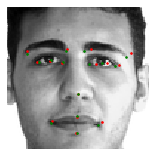

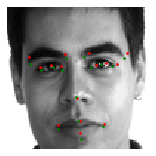

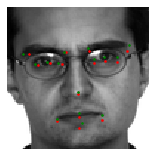

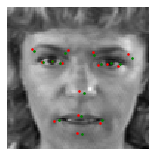

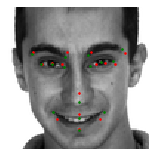

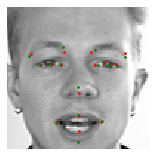

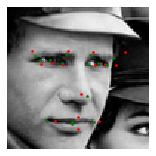

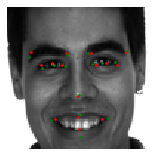

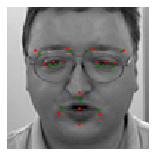

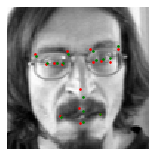

In [737]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:
visualize_output(test_images, test_outputs, gt_pts)

In [738]:
def net_true_test_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(true_test_loader):
        
        # get images
        images = sample['image']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)
        
        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 15 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 15, -1)
        
        # don't break after first image is tested
        return images, output_pts

In [739]:
# Do the "true" test with actual test data

# Get true test dataset in the right format
true_test_dataset = FacialKeypointsDataset(dataframe=test_raw,
                                             transform=data_transform)

# load true test data in batches
true_test_loader = DataLoader(true_test_dataset, batch_size=len(test_raw.index))

# returns: test images, test predicted keypoints, test ground truth keypoints
true_test_images, true_test_outputs = net_true_test_output()

print(true_test_images.data.size())
print(true_test_outputs.data.size())

torch.Size([1783, 1, 96, 96])
torch.Size([1783, 15, 2])


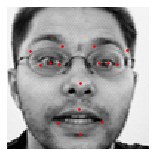

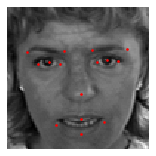

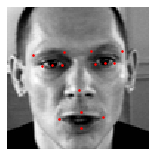

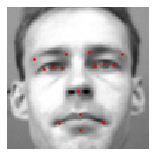

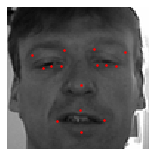

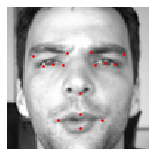

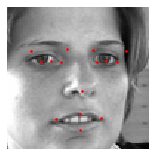

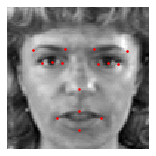

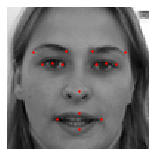

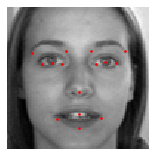

In [740]:
# Visualize true_test outputs
visualize_output(true_test_images, true_test_outputs)

In [741]:
# Get submission file
sub = pd.read_csv('IdLookupTable.csv')

# Un-transform keypoints
predicted_key_pts = true_test_outputs.data
predicted_key_pts = predicted_key_pts.numpy()
# undo normalization of keypoints  
predicted_key_pts = predicted_key_pts*48.0+48
# print(predicted_key_pts[0])

for i, keypoints in enumerate(predicted_key_pts):
    sub.loc[(sub['ImageId'] == (i+1)) & (sub['FeatureName'] == 'left_eye_center_x'),'Location'] = keypoints[0][0]
    sub.loc[(sub['ImageId'] == (i+1)) & (sub['FeatureName'] == 'left_eye_center_y'),'Location'] = keypoints[0][1]
    sub.loc[(sub['ImageId'] == (i+1)) & (sub['FeatureName'] == 'right_eye_center_x'),'Location'] = keypoints[1][0]
    sub.loc[(sub['ImageId'] == (i+1)) & (sub['FeatureName'] == 'right_eye_center_y'),'Location'] = keypoints[1][1]
    sub.loc[(sub['ImageId'] == (i+1)) & (sub['FeatureName'] == 'left_eye_inner_corner_x'),'Location'] = keypoints[2][0]
    sub.loc[(sub['ImageId'] == (i+1)) & (sub['FeatureName'] == 'left_eye_inner_corner_y'),'Location'] = keypoints[2][1]
    sub.loc[(sub['ImageId'] == (i+1)) & (sub['FeatureName'] == 'left_eye_outer_corner_x'),'Location'] = keypoints[3][0]
    sub.loc[(sub['ImageId'] == (i+1)) & (sub['FeatureName'] == 'left_eye_outer_corner_y'),'Location'] = keypoints[3][1]
    sub.loc[(sub['ImageId'] == (i+1)) & (sub['FeatureName'] == 'right_eye_inner_corner_x'),'Location'] = keypoints[4][0]
    sub.loc[(sub['ImageId'] == (i+1)) & (sub['FeatureName'] == 'right_eye_inner_corner_y'),'Location'] = keypoints[4][1]
    sub.loc[(sub['ImageId'] == (i+1)) & (sub['FeatureName'] == 'right_eye_outer_corner_x'),'Location'] = keypoints[5][0]
    sub.loc[(sub['ImageId'] == (i+1)) & (sub['FeatureName'] == 'right_eye_outer_corner_y'),'Location'] = keypoints[5][1]
    sub.loc[(sub['ImageId'] == (i+1)) & (sub['FeatureName'] == 'left_eyebrow_inner_end_x'),'Location'] = keypoints[6][0]
    sub.loc[(sub['ImageId'] == (i+1)) & (sub['FeatureName'] == 'left_eyebrow_inner_end_y'),'Location'] = keypoints[6][1]
    sub.loc[(sub['ImageId'] == (i+1)) & (sub['FeatureName'] == 'left_eyebrow_outer_end_x'),'Location'] = keypoints[7][0]
    sub.loc[(sub['ImageId'] == (i+1)) & (sub['FeatureName'] == 'left_eyebrow_outer_end_y'),'Location'] = keypoints[7][1]
    sub.loc[(sub['ImageId'] == (i+1)) & (sub['FeatureName'] == 'right_eyebrow_inner_end_x'),'Location'] = keypoints[8][0]
    sub.loc[(sub['ImageId'] == (i+1)) & (sub['FeatureName'] == 'right_eyebrow_inner_end_y'),'Location'] = keypoints[8][1]
    sub.loc[(sub['ImageId'] == (i+1)) & (sub['FeatureName'] == 'right_eyebrow_outer_end_x'),'Location'] = keypoints[9][0]
    sub.loc[(sub['ImageId'] == (i+1)) & (sub['FeatureName'] == 'right_eyebrow_outer_end_y'),'Location'] = keypoints[9][1]
    sub.loc[(sub['ImageId'] == (i+1)) & (sub['FeatureName'] == 'nose_tip_x'),'Location'] = keypoints[10][0]
    sub.loc[(sub['ImageId'] == (i+1)) & (sub['FeatureName'] == 'nose_tip_y'),'Location'] = keypoints[10][1]
    sub.loc[(sub['ImageId'] == (i+1)) & (sub['FeatureName'] == 'mouth_left_corner_x'),'Location'] = keypoints[11][0]
    sub.loc[(sub['ImageId'] == (i+1)) & (sub['FeatureName'] == 'mouth_left_corner_y'),'Location'] = keypoints[11][1]
    sub.loc[(sub['ImageId'] == (i+1)) & (sub['FeatureName'] == 'mouth_right_corner_x'),'Location'] = keypoints[12][0]
    sub.loc[(sub['ImageId'] == (i+1)) & (sub['FeatureName'] == 'mouth_right_corner_y'),'Location'] = keypoints[12][1]
    sub.loc[(sub['ImageId'] == (i+1)) & (sub['FeatureName'] == 'mouth_center_top_lip_x'),'Location'] = keypoints[13][0]
    sub.loc[(sub['ImageId'] == (i+1)) & (sub['FeatureName'] == 'mouth_center_top_lip_y'),'Location'] = keypoints[13][1]
    sub.loc[(sub['ImageId'] == (i+1)) & (sub['FeatureName'] == 'mouth_center_bottom_lip_x'),'Location'] = keypoints[14][0]
    sub.loc[(sub['ImageId'] == (i+1)) & (sub['FeatureName'] == 'mouth_center_bottom_lip_y'),'Location'] = keypoints[14][1]


    

In [742]:
sub.head

<bound method NDFrame.head of        RowId  ImageId                FeatureName   Location
0          1        1          left_eye_center_x  67.433586
1          2        1          left_eye_center_y  37.299679
2          3        1         right_eye_center_x  28.395588
3          4        1         right_eye_center_y  37.570911
4          5        1    left_eye_inner_corner_x  61.308292
...      ...      ...                        ...        ...
27119  27120     1783         right_eye_center_y  37.787373
27120  27121     1783                 nose_tip_x  46.126949
27121  27122     1783                 nose_tip_y  58.677147
27122  27123     1783  mouth_center_bottom_lip_x  48.091278
27123  27124     1783  mouth_center_bottom_lip_y  80.650673

[27124 rows x 4 columns]>

In [743]:
sub.loc[sub.Location > 96.0, 'Location'] = 96.0
sub.loc[sub.Location < 0.0, 'Location'] = 0.0

pruned_sub = sub.drop(['ImageId', 'FeatureName'], axis=1)
pruned_sub.to_csv('submission.csv', index=False)